# GAN Camel Analysis

In [1]:
import torch as t
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from models.GAN import build_generator, build_critic

camel_file = 'data/camel/full_numpy_bitmap_camel.npy'
X = t.from_numpy(np.load(camel_file)[:25000]).float()
X = X.view(25000, 1, 28, 28) / 255
z_dim = 100

generator = build_generator(gen_init_size=(64, 7, 7), gen_upsample_flags=[True, True, False, False], 
                            gen_c=[128, 64, 64, 1],gen_ks=[5, 5, 5, 5], gen_strides=[1, 1, 1, 1], 
                            gen_pads=[2, 2, 2, 2], z_dim=z_dim)

critic = build_critic(X[0][None], critic_c=[1, 64, 64, 128, 128], critic_ks=[5, 5, 5, 5], 
                      critic_strides=[2, 2, 2, 1], critic_pads=[2, 2, 2, 2])


generator.load_state_dict(t.load('models/state_dicts/04_01_gen.pth'))
critic.load_state_dict(t.load('models/state_dicts/04_01_critic.pth'))


device = t.device('cuda') if t.cuda.is_available() else 'cpu'
generator.cuda(device)
critic.cuda(device)

train_loader = DataLoader(TensorDataset(X, X), batch_size=1, shuffle=True, drop_last=True)

In [2]:
m, n = 5, 5
sampled_gen_imgs = list(generator(t.randn(m * n, z_dim).to(device)))
most_similar_imgs = []

for sampled_gen_img in sampled_gen_imgs:
    min_img, min_dist = X[0][None], float('inf')
    for img, _ in train_loader:
        dist = t.mean(F.pairwise_distance(img.to(device), sampled_gen_img))
        if dist < min_dist:
            min_img = img
            min_dist = dist
    most_similar_imgs.append(min_img.data)

### Generated imgs

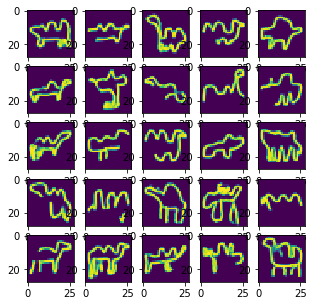

In [3]:
row, col = m, n

f, axarr = plt.subplots(row, col, figsize=(m, n))
i = 0
for r in range(row):
    for c in range(col):
        axarr[r, c].imshow(sampled_gen_imgs[i].detach().cpu().squeeze())
        i += 1

### Most similar real imgs

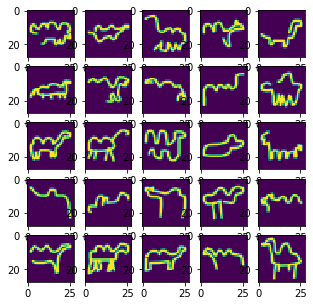

In [4]:
row, col = m, n

f, axarr = plt.subplots(row, col, figsize=(m, n))
i = 0
for r in range(row):
    for c in range(col):
        axarr[r, c].imshow(most_similar_imgs[i].detach().cpu().squeeze())
        i += 1